#### Imports

In [1]:
#Adding working directory to python path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [48]:
#Import function to laod and process dataset
from utils.data_processing import *

#Standard import
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Parameters

In [3]:
FILE = 'MRec40'  # MRec40, ZRec50 or ZRec50_Mini
PATH = f'../data/Objects Task DL Project/{FILE}.neo.mat' 
PLOTS_FOLDER = '../plots/dataset'
EPOCH = 'all'

### Plotting functions

In [154]:
def display_dataset_distribution(unique_class, n_repetition, class_name='classes'):
    fig, ax = plt.subplots(figsize = (18 - (36-len(unique_class))*8/31, 5))
    rects = ax.bar(list(range(len(unique_class))), n_repetition, alpha=0.7)
    ax.set_xticks(list(range(len(unique_class))))
    ax.set_xticklabels(unique_class)

    ax.set_ylim([0, max(n_repetition)*1.15])
    ax.axhline(y=n_repetition.mean(), color='midnightblue', linestyle='-', label='mean', lw=1.5)
    ax.axhspan(n_repetition.mean()-n_repetition.std(), n_repetition.mean()+n_repetition.std(), alpha=0.3, color='orange', label='std')
    ax.set_xlabel('class', fontsize=12)
    ax.set_ylabel('repetitions', fontsize=12)
    ax.set_title(f'Distribution of {class_name} examples in the dataset', fontsize=14)
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
    plt.legend()
    plt.tight_layout()
    fig.savefig(f'{PLOTS_FOLDER}/{class_name.replace(" ", "_")}_distribution.png')
    plt.show()

In [5]:
# Load dataset
all_measurements, all_objects, all_states = load_dataset(PATH, EPOCH, load_states=True)

36 408


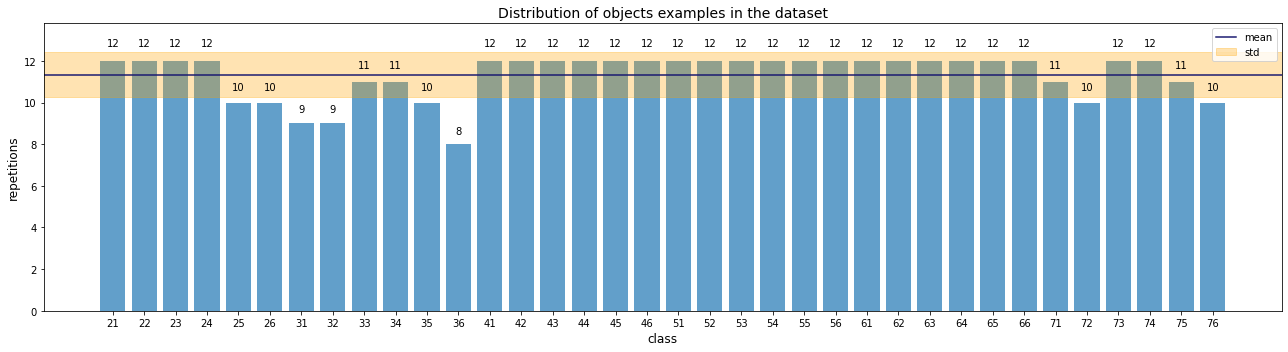

In [155]:
# Studio la distribuzione degli oggetti
unique_obj, n_repetition = np.unique(all_objects, return_counts=True, axis=0)
display_dataset_distribution(unique_obj[8:-6], n_repetition[8:-6], 'objects')
print(len(n_repetition[8:-6]), sum(n_repetition[8:-6]))

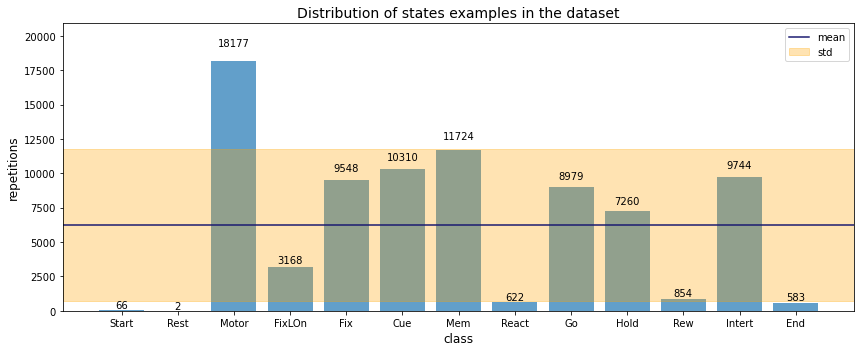

In [156]:
# Studio la distribuzione degli states
unique_states, n_repetition = np.unique(all_states.flatten(), return_counts=True, axis=0)
unique_states = np.array([x.strip() for x in unique_states])

# Reordering the labels to match the chronological order of phases instead of the alphabetical one
states_order = []
ordered_states = ['Start', 'Rest', 'Motor', 'FixLOn', 'Fix', 'Cue', 'Mem', 'React', 'Go', 'Hold', 'Rew', 'Intert', 'End']
for ep in ordered_states:
    states_order.append(list(unique_states).index(ep))

display_dataset_distribution(unique_states[states_order], n_repetition[states_order], 'states')